# Pseudobulk differential expression to compare pGL2-BRI1-GFP/bri1-T to WT

In [1]:
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(muscat)
library(purrr)
library(limma)
library(scran)
library(future)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Attaching SeuratObject


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualizati

In [2]:
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

In [3]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: AlmaLinux 9.3 (Shamrock Pampas Cat)

Matrix products: default
BLAS/LAPACK: /hpc/group/pbenfeylab/tmn23/miniconda3/envs/muscat/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] future_1.31.0               scran_1.26.0               
 [3] scuttle_1.8.0               SingleCellExperiment_1.20.0
 [5] SummarizedExperiment_1.28.0 Biobase_2.58.0             
 [7] GenomicRanges_1.50.0        GenomeInfoDb_1.34.8        
 [9]

In [4]:
rc.integrated <- readRDS("../../CheWei/scRNA-seq/Integrated_Objects/rc.integrated_4S_GL2_lines_seu4_annotated_20240226.rds")

In [5]:
rc.integrated

An object of class Seurat 
71562 features across 24982 samples within 3 assays 
Active assay: SCT (24786 features, 0 variable features)
 2 other assays present: RNA, integrated
 3 dimensional reductions calculated: pca, umap, umap_2D

## Cell type and developmental stage metadata

- Developmental stage: `time_zone`
- Cell type:`cell_type`
- Combination of cell type and developmental stage: `time_zone_cell_type`
- Combination of cell type and developmental stage with cell subtypes (not used): `time_zone_cell_subtypes` 

In [6]:
feature_names <- read_tsv("../data/features.tsv.gz", col_names = c("AGI", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()

Rows: 32833 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): AGI, Name, Type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
table(rc.integrated$geno)


                  WT pGL2_BRI1_GFP_bri1_T 
               14493                10489 

In [8]:
table(rc.integrated$geno, rc.integrated$orig.ident)

                      
                       sc_130 sc_133 sc_134 sc_137
  WT                     6656      0   7837      0
  pGL2_BRI1_GFP_bri1_T      0   8424      0   2065

In [9]:
table(rc.integrated$geno)


                  WT pGL2_BRI1_GFP_bri1_T 
               14493                10489 

# Differential State Analysis with Muscat

In [10]:
#  samples you want to compare

integrated.de <- rc.integrated
integrated.de$genotype <- integrated.de$geno

In [11]:
integrated.de

An object of class Seurat 
71562 features across 24982 samples within 3 assays 
Active assay: SCT (24786 features, 0 variable features)
 2 other assays present: RNA, integrated
 3 dimensional reductions calculated: pca, umap, umap_2D

## Convert to sce

In [12]:
#  construct sce manually
my_metadata <- data.frame(sample_id = integrated.de$orig.ident,
                              group_id = integrated.de$genotype,
                              cluster_id = integrated.de$cell_type, 
                             rep=integrated.de$rep) # include experimental rep as co-variate

sce <- SingleCellExperiment(assays = list(counts = integrated.de@assays$RNA@counts),
	                            colData = my_metadata)

In [13]:
    (sce <- prepSCE(sce, 
        kid = "cluster_id", # subpopulation assignments
        gid = "group_id",   # group IDs (ctrl/stim)
        sid = "sample_id",    # sample IDs (ctrl/stim.1234)
        drop = FALSE))        # drop all other colData columns

class: SingleCellExperiment 
dim: 29444 24982 
metadata(1): experiment_info
assays(1): counts
rownames(29444): AT1G01010 AT1G01020 ... AT5G09785 ATCG00100
rowData names(0):
colnames(24982): AAACCCACAACAGCCC_4 AAACCCACAGAGTAAT_4 ...
  TTTGGTTTCTGGGCCA_7 TTTGGTTTCTTCACAT_7
colData names(4): cluster_id sample_id group_id rep
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

## pre-filtering

In [14]:
# remove undetected genes
sce <- sce[rowSums(counts(sce) > 0) > 0, ]
dim(sce)

[1] 26828 24982

In [15]:
# remove lowly expressed genes
sce <- sce[rowSums(counts(sce) > 1) >= 1, ]
dim(sce)

[1] 22928 24982

In [16]:
# create pseudobulk profiles
pb <- aggregateData(sce,
    assay = "counts", fun = "sum",
    by = c("cluster_id", "sample_id"))
# one sheet per subpopulation
assayNames(pb)

[1] "Columella"        "Lateral Root Cap" "Atrichoblast"     "Trichoblast"     
 [5] "Cortex"           "Endodermis"       "Phloem"           "Xylem"           
 [9] "Procambium"       "Pericycle"

In [17]:
# pseudobulks for 1st subpopulation
t(head(assay(pb)))

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060
sc_130,65,92,20,14,1823,3
sc_133,45,72,13,18,808,3
sc_134,44,73,16,18,1204,4
sc_137,63,86,48,25,702,9


In [18]:
# metadata to manually add to DE contrast
bscs <- read.csv("../data/Benfey_single_cell_20230703.csv", na.strings=c("","NA"), stringsAsFactors = F)
bscs$date <- gsub('^([0-9]{4})([0-9]{2})([0-9]+)$', '\\1-\\2-\\3', bscs$date)

In [19]:
# experiment info for contrasts, add rep from csv

ei <- metadata(sce)$experiment_info
ei

sample_date <- select(bscs, sample_id=sample, rep=rep)

ei <- left_join(ei, sample_date)

ei

sample_id,group_id,n_cells
<fct>,<fct>,<dbl>
sc_130,WT,6656
sc_134,WT,7837
sc_133,pGL2_BRI1_GFP_bri1_T,8424
sc_137,pGL2_BRI1_GFP_bri1_T,2065


Joining with `by = join_by(sample_id)`


sample_id,group_id,n_cells,rep
<chr>,<fct>,<dbl>,<chr>
sc_130,WT,6656,1
sc_134,WT,7837,2
sc_133,pGL2_BRI1_GFP_bri1_T,8424,1
sc_137,pGL2_BRI1_GFP_bri1_T,2065,2


In [20]:
mm <- model.matrix(~ 0 + ei$group_id + ei$rep)
dimnames(mm) <- list(ei$sample_id, c(levels(ei$group_id), "rep"))

mm

,WT,pGL2_BRI1_GFP_bri1_T,rep
sc_130,1,0,0
sc_134,1,0,1
sc_133,0,1,0
sc_137,0,1,1


In [21]:
contrast <- makeContrasts("pGL2_BRI1_GFP_bri1_T-WT",
                          levels = mm)

contrast

,pGL2_BRI1_GFP_bri1_T-WT
WT,-1
pGL2_BRI1_GFP_bri1_T,1
rep,0


In [22]:
res <- pbDS(pb, design = mm, 
            contrast = contrast, 
            method="edgeR", 
            min_cells=5, 
            filter = c("none"))

  |======================================================================| 100%



### DEG results

In [23]:
# DEG results with gene freqs
(res_to_write_frq <- resDS(sce, res, bind = "row", cpm=TRUE, frq=T))

gene,cluster_id,sc_130.cpm,sc_134.cpm,sc_133.cpm,sc_137.cpm,sc_130.frq,sc_134.frq,sc_133.frq,sc_137.frq,WT.frq,pGL2_BRI1_GFP_bri1_T.frq,logFC,logCPM,F,p_val,p_adj.loc,p_adj.glb,contrast
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AT1G01010,Columella,9.720,9.210,9.570,12.400,0.06940,0.0646,0.07440,0.15600,0.067500,0.10000,0.2030,3.4100,0.3810,0.54300,0.8520,0.8260,pGL2_BRI1_GFP_bri1_T-WT
AT1G01020,Columella,13.800,15.300,15.300,16.900,0.09180,0.1020,0.09420,0.20200,0.095900,0.12900,0.1520,3.9700,0.2440,0.62600,0.8770,0.8630,pGL2_BRI1_GFP_bri1_T-WT
AT1G01030,Columella,2.990,3.350,2.770,9.450,0.02130,0.0238,0.01980,0.10600,0.022300,0.04740,0.7680,2.3200,2.9300,0.10100,0.5090,0.3880,pGL2_BRI1_GFP_bri1_T-WT
AT1G01040,Columella,2.090,3.770,3.830,4.920,0.01570,0.0306,0.02480,0.07090,0.021600,0.03950,0.6090,1.9900,1.8400,0.18800,0.6450,0.5390,pGL2_BRI1_GFP_bri1_T-WT
AT1G01050,Columella,273.000,252.000,172.000,138.000,0.75900,0.7180,0.62800,0.73000,0.743000,0.66100,-0.7650,7.7100,10.5000,0.00364,0.0905,0.0470,pGL2_BRI1_GFP_bri1_T-WT
AT1G01060,Columella,0.449,0.837,0.638,1.770,0.00336,0.0068,0.00496,0.02130,0.004730,0.01010,0.8300,0.3550,0.7250,0.40300,0.8110,0.7520,pGL2_BRI1_GFP_bri1_T-WT
AT1G01070,Columella,0.150,0.209,0.000,0.197,0.00112,0.0017,0.00000,0.00355,0.001350,0.00113,-0.8030,-0.9500,0.0974,0.75800,0.9300,0.9130,pGL2_BRI1_GFP_bri1_T-WT
AT1G01080,Columella,0.449,0.419,1.910,1.770,0.00336,0.0034,0.01320,0.02130,0.003380,0.01580,2.0300,0.5600,5.0900,0.03420,0.3040,0.2070,pGL2_BRI1_GFP_bri1_T-WT
AT1G01090,Columella,38.100,37.900,37.900,36.200,0.23600,0.2520,0.23000,0.33700,0.242000,0.26400,-0.0368,5.2400,0.0182,0.89400,0.9780,0.9660,pGL2_BRI1_GFP_bri1_T-WT


In [24]:
## all genes background 

all_bg <- res_to_write_frq

In [25]:
length(unique(all_bg$gene))

[1] 22928

In [26]:
#total DE genes p_adj.loc < 0.05, abs(logFC) > 1.5
sig_DE <- filter(res_to_write_frq, p_adj.loc<=0.05 & abs(logFC) > log2(1.5))
sig_DE <- left_join(sig_DE, feature_names, by=c("gene"="AGI"))

length(unique(sig_DE$gene))

[1] 10743

In [27]:
# filter gene freqs to avoid calling lowly detected genes
sig_DE_fil <- filter(sig_DE, 
                     WT.frq >=0.1 | pGL2_BRI1_GFP_bri1_T.frq >=0.1)

In [28]:
length(unique(sig_DE_fil$gene))

[1] 7266

In [29]:
# load TFs
TF_list <- read_csv("../data/Kay_TF_thalemine_annotations.csv", col_names = c("gene", "TF_Name", "Description")) 

Rows: 2485 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): gene, TF_Name, Description

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [30]:
sig_DE_fil <- left_join(sig_DE_fil, TF_list)

Joining with `by = join_by(gene)`


In [31]:
# label up vs down
sig_DE_fil <- sig_DE_fil %>%
  mutate(up_dn_label = case_when(logFC >=log2(1.5) ~ "Up",  
                                       logFC <=log2(1/1.5) ~ "Down",
                                       TRUE ~ "Not DE"))

sig_DE_fil$clust_up_dn <- paste(sig_DE_fil$cluster_id, sig_DE_fil$up_dn_label, sep="_")

sig_DE_fil

gene,cluster_id,sc_130.cpm,sc_134.cpm,sc_133.cpm,sc_137.cpm,sc_130.frq,sc_134.frq,sc_133.frq,sc_137.frq,⋯,F,p_val,p_adj.loc,p_adj.glb,contrast,Name,TF_Name,Description,up_dn_label,clust_up_dn
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AT1G01140,Columella,23.90,16.10,9.15,7.88,0.1570,0.1160,0.0678,0.1210,⋯,14.3,1.01e-03,4.19e-02,1.91e-02,pGL2_BRI1_GFP_bri1_T-WT,CIPK9,NA,NA,Down,Columella_Down
AT1G01620,Columella,639.00,349.00,262.00,132.00,0.9310,0.7980,0.6580,0.5960,⋯,34.7,5.82e-06,1.28e-03,4.09e-04,pGL2_BRI1_GFP_bri1_T-WT,PIP1-3,NA,NA,Down,Columella_Down
AT1G02870,Columella,5.83,16.10,18.90,28.00,0.0381,0.0901,0.1070,0.1600,⋯,13.9,1.15e-03,4.55e-02,2.09e-02,pGL2_BRI1_GFP_bri1_T-WT,AT1G02870,NA,NA,Up,Columella_Up
AT1G03870,Columella,226.00,106.00,57.60,28.40,0.6840,0.4850,0.3010,0.3050,⋯,56.6,1.42e-07,1.14e-04,2.62e-05,pGL2_BRI1_GFP_bri1_T-WT,FLA9,NA,NA,Down,Columella_Down
AT1G04040,Columella,539.00,259.00,146.00,82.50,0.9660,0.8200,0.5920,0.6170,⋯,54.8,1.84e-07,1.24e-04,3.16e-05,pGL2_BRI1_GFP_bri1_T-WT,AT1G04040,NA,NA,Down,Columella_Down
AT1G04410,Columella,613.00,538.00,411.00,247.00,0.9690,0.9340,0.9060,0.9220,⋯,13.8,1.17e-03,4.57e-02,2.12e-02,pGL2_BRI1_GFP_bri1_T-WT,MDH1,NA,NA,Down,Columella_Down
AT1G04610,Columella,34.70,26.20,101.00,86.50,0.0705,0.0629,0.1790,0.1630,⋯,37.5,3.34e-06,8.39e-04,2.69e-04,pGL2_BRI1_GFP_bri1_T-WT,YUC3,NA,NA,Up,Columella_Up
AT1G05010,Columella,3090.00,2560.00,1570.00,1290.00,0.9290,0.9000,0.7440,0.8190,⋯,26.7,3.32e-05,4.11e-03,1.54e-03,pGL2_BRI1_GFP_bri1_T-WT,ACO4,NA,NA,Down,Columella_Down
AT1G06080,Columella,3.29,1.67,41.70,13.60,0.0202,0.0119,0.1740,0.1600,⋯,81.4,6.33e-09,1.47e-05,2.31e-06,pGL2_BRI1_GFP_bri1_T-WT,ADS1,NA,NA,Up,Columella_Up


In [32]:
sig_DE_fil
write.csv(sig_DE_fil, file = "../output/pGL2-BRI1-GFP_celltype_EdgeR_q0.05_FC1.5_r_v_4_20240314.csv")

gene,cluster_id,sc_130.cpm,sc_134.cpm,sc_133.cpm,sc_137.cpm,sc_130.frq,sc_134.frq,sc_133.frq,sc_137.frq,⋯,F,p_val,p_adj.loc,p_adj.glb,contrast,Name,TF_Name,Description,up_dn_label,clust_up_dn
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AT1G01140,Columella,23.90,16.10,9.15,7.88,0.1570,0.1160,0.0678,0.1210,⋯,14.3,1.01e-03,4.19e-02,1.91e-02,pGL2_BRI1_GFP_bri1_T-WT,CIPK9,NA,NA,Down,Columella_Down
AT1G01620,Columella,639.00,349.00,262.00,132.00,0.9310,0.7980,0.6580,0.5960,⋯,34.7,5.82e-06,1.28e-03,4.09e-04,pGL2_BRI1_GFP_bri1_T-WT,PIP1-3,NA,NA,Down,Columella_Down
AT1G02870,Columella,5.83,16.10,18.90,28.00,0.0381,0.0901,0.1070,0.1600,⋯,13.9,1.15e-03,4.55e-02,2.09e-02,pGL2_BRI1_GFP_bri1_T-WT,AT1G02870,NA,NA,Up,Columella_Up
AT1G03870,Columella,226.00,106.00,57.60,28.40,0.6840,0.4850,0.3010,0.3050,⋯,56.6,1.42e-07,1.14e-04,2.62e-05,pGL2_BRI1_GFP_bri1_T-WT,FLA9,NA,NA,Down,Columella_Down
AT1G04040,Columella,539.00,259.00,146.00,82.50,0.9660,0.8200,0.5920,0.6170,⋯,54.8,1.84e-07,1.24e-04,3.16e-05,pGL2_BRI1_GFP_bri1_T-WT,AT1G04040,NA,NA,Down,Columella_Down
AT1G04410,Columella,613.00,538.00,411.00,247.00,0.9690,0.9340,0.9060,0.9220,⋯,13.8,1.17e-03,4.57e-02,2.12e-02,pGL2_BRI1_GFP_bri1_T-WT,MDH1,NA,NA,Down,Columella_Down
AT1G04610,Columella,34.70,26.20,101.00,86.50,0.0705,0.0629,0.1790,0.1630,⋯,37.5,3.34e-06,8.39e-04,2.69e-04,pGL2_BRI1_GFP_bri1_T-WT,YUC3,NA,NA,Up,Columella_Up
AT1G05010,Columella,3090.00,2560.00,1570.00,1290.00,0.9290,0.9000,0.7440,0.8190,⋯,26.7,3.32e-05,4.11e-03,1.54e-03,pGL2_BRI1_GFP_bri1_T-WT,ACO4,NA,NA,Down,Columella_Down
AT1G06080,Columella,3.29,1.67,41.70,13.60,0.0202,0.0119,0.1740,0.1600,⋯,81.4,6.33e-09,1.47e-05,2.31e-06,pGL2_BRI1_GFP_bri1_T-WT,ADS1,NA,NA,Up,Columella_Up


In [33]:
# add DE and up/dn to total list
sig_to_join <- sig_DE_fil %>%
mutate(clust_gene=paste(cluster_id, gene, contrast, sep="_")) %>%
select(clust_gene, up_dn_label, clust_up_dn)

In [34]:
# join all genes list to DE labels
all_bg <- mutate(all_bg, clust_gene=paste(cluster_id, gene, contrast, sep="_"))

all_bg <- left_join(all_bg, feature_names, by=c("gene"="AGI"))

all_bg$DE <- all_bg$clust_gene %in% sig_to_join$clust_gene


all_bg <- all_bg %>%
left_join(sig_to_join, by="clust_gene") %>%
arrange(all_bg, p_adj.loc)

write.csv(all_bg, file = "../output/all_pGL2-BRI1-GFP_celltype_EdgeR_q0.05_FC1.5_r_v_4_20240314.csv")

In [35]:
nb_genes_per_clust <- sig_DE_fil  %>%
  group_by(cluster_id) %>%
  tally()

# color up and down

nb_up_dn <- sig_DE_fil  %>%
  group_by(cluster_id, up_dn_label) %>%
  tally(name = "n_up_dn") %>%
left_join(nb_genes_per_clust)

nb_up_dn

Joining with `by = join_by(cluster_id)`


cluster_id,up_dn_label,n_up_dn,n
<chr>,<chr>,<int>,<int>
Atrichoblast,Down,3467,5466
Atrichoblast,Up,1999,5466
Columella,Down,232,342
Columella,Up,110,342
Cortex,Down,762,1204
Cortex,Up,442,1204
Endodermis,Down,120,174
Endodermis,Up,54,174
Lateral Root Cap,Down,879,1293


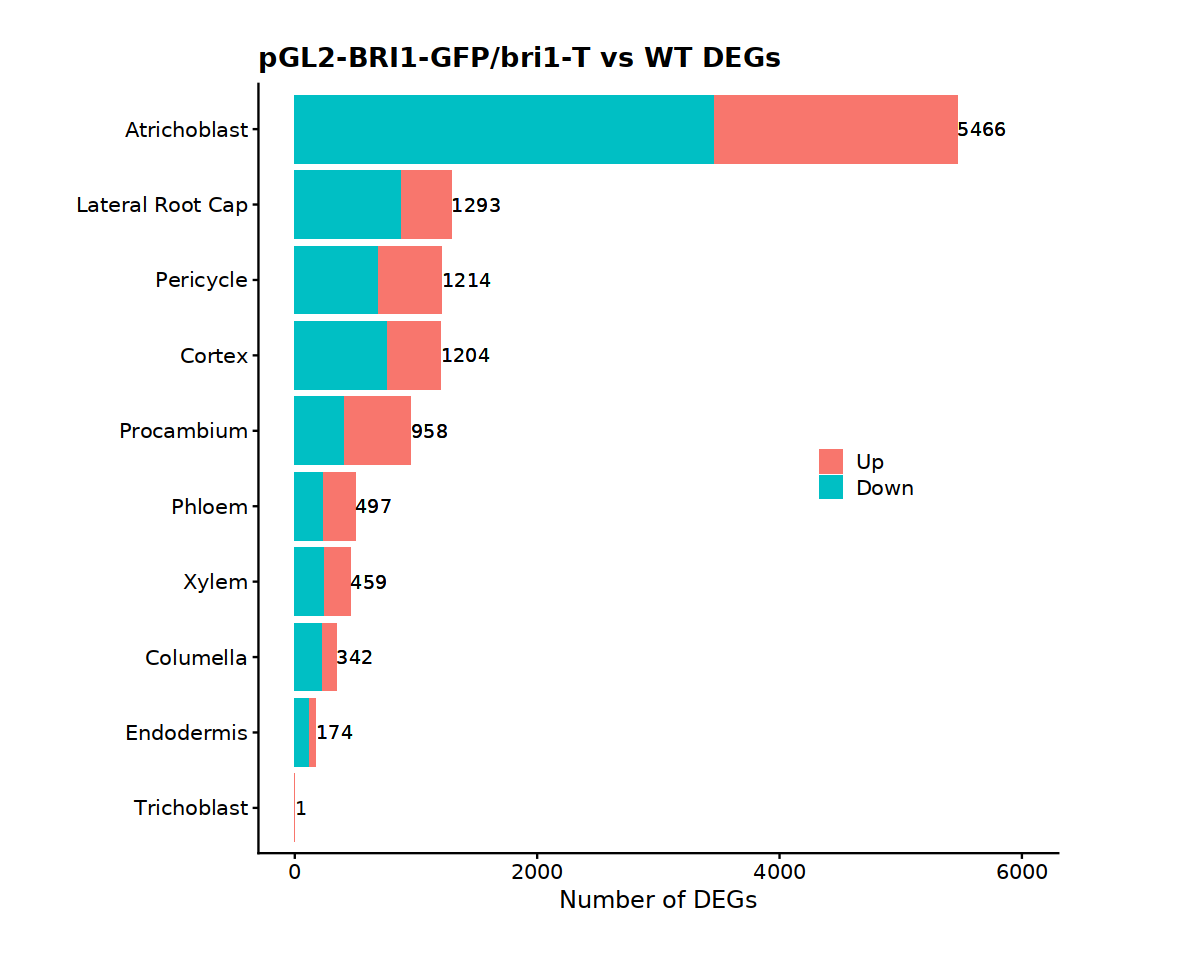

In [36]:
options(repr.plot.width=10, repr.plot.height=8)

nb_v <- ggplot(data=nb_up_dn, aes(x=reorder(cluster_id, n), y=n_up_dn, fill=factor(up_dn_label, levels=c("Up", "Down")))) +
  geom_bar(stat="identity", position="stack") + ylab("Number of DEGs") + xlab("") + 
scale_y_continuous(limits = c(0, 6000)) +
geom_text(aes(label=n, y = n), hjust=0, vjust=0.5, size=4)  + 
theme_cowplot()  +theme(plot.margin = margin(1,3,1,1, "cm"), 
                        legend.title=element_blank(), 
                       legend.position = c(0.7, 0.5)) + ggtitle("pGL2-BRI1-GFP/bri1-T vs WT DEGs")

(CVP_v_WT <- nb_v + coord_flip())

ggsave("../output/GL2/pGL2vsWT_DEG_barplot_cell_type.pdf", width=10, height=8)

In [37]:
# GO enrichment of DEGs

markers_sel <- select(sig_DE_fil, gene, clust_up_dn)

markers_list <- split(markers_sel, f=markers_sel$clust_up_dn)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="gene"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$gene)))

cluster_GO <- gost(markers_list, organism = "athaliana", correction_method = "fdr", significant = F, multi_query = F)

In [38]:
cluster_GO_df <- cluster_GO[[1]]

cluster_GO_sig <- filter(cluster_GO_df, p_value<=0.01)

# top  terms for each cluster

cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=8) %>%
  group_by(query) %>%
  top_n(2, wt = -p_value) %>%
  arrange(desc(p_value)) -> top_GO

GO_n <- cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=8) %>%
  group_by(term_id) %>%
  tally() %>%
  arrange(desc(n))


GO_n <- dplyr::rename(GO_n, "n_clusters"=n)

cluster_GO_sig_n <- left_join(cluster_GO_sig, GO_n)

# get all terms for the top ones so that all clusters have values

top_GO_all <- filter(cluster_GO_df, term_id %in% top_GO$term_id)


#spread and plot


top_GO_sel <- select(top_GO_all, query, p_value, term_id, term_name)

spread_GO <- spread(top_GO_sel, key = query, p_value)

spread_GO[is.na(spread_GO)] <- 1

spread_GO_m <- as.matrix(-log10(spread_GO[3:ncol(spread_GO)]))
rownames(spread_GO_m) <- spread_GO$term_name


spread_GO_m_t <- t(spread_GO_m)

GO_hm_t <- Heatmap(spread_GO_m_t, 
                 name = "-log10_pval", 
                 heatmap_legend_param = list(title_position="leftcenter-rot", color_bar = "continuous"), 
                 col = colorRamp2(c(0, 20), c("beige", "darkgreen")), 
                 cluster_rows = T, 
                 cluster_columns = T, 
                 use_raster= FALSE, 
                 show_column_names = TRUE, 
                 show_row_names = TRUE, 
                 show_row_dend = TRUE, 
                 show_column_dend = TRUE,
                 column_names_rot = 45,
                 clustering_distance_columns = "pearson", 
                 clustering_distance_rows = "pearson",
                 row_names_gp = gpar(fontsize = 14), 
                column_names_gp = gpar(fontsize = 14)) 

Joining with `by = join_by(term_id)`


png 
  2

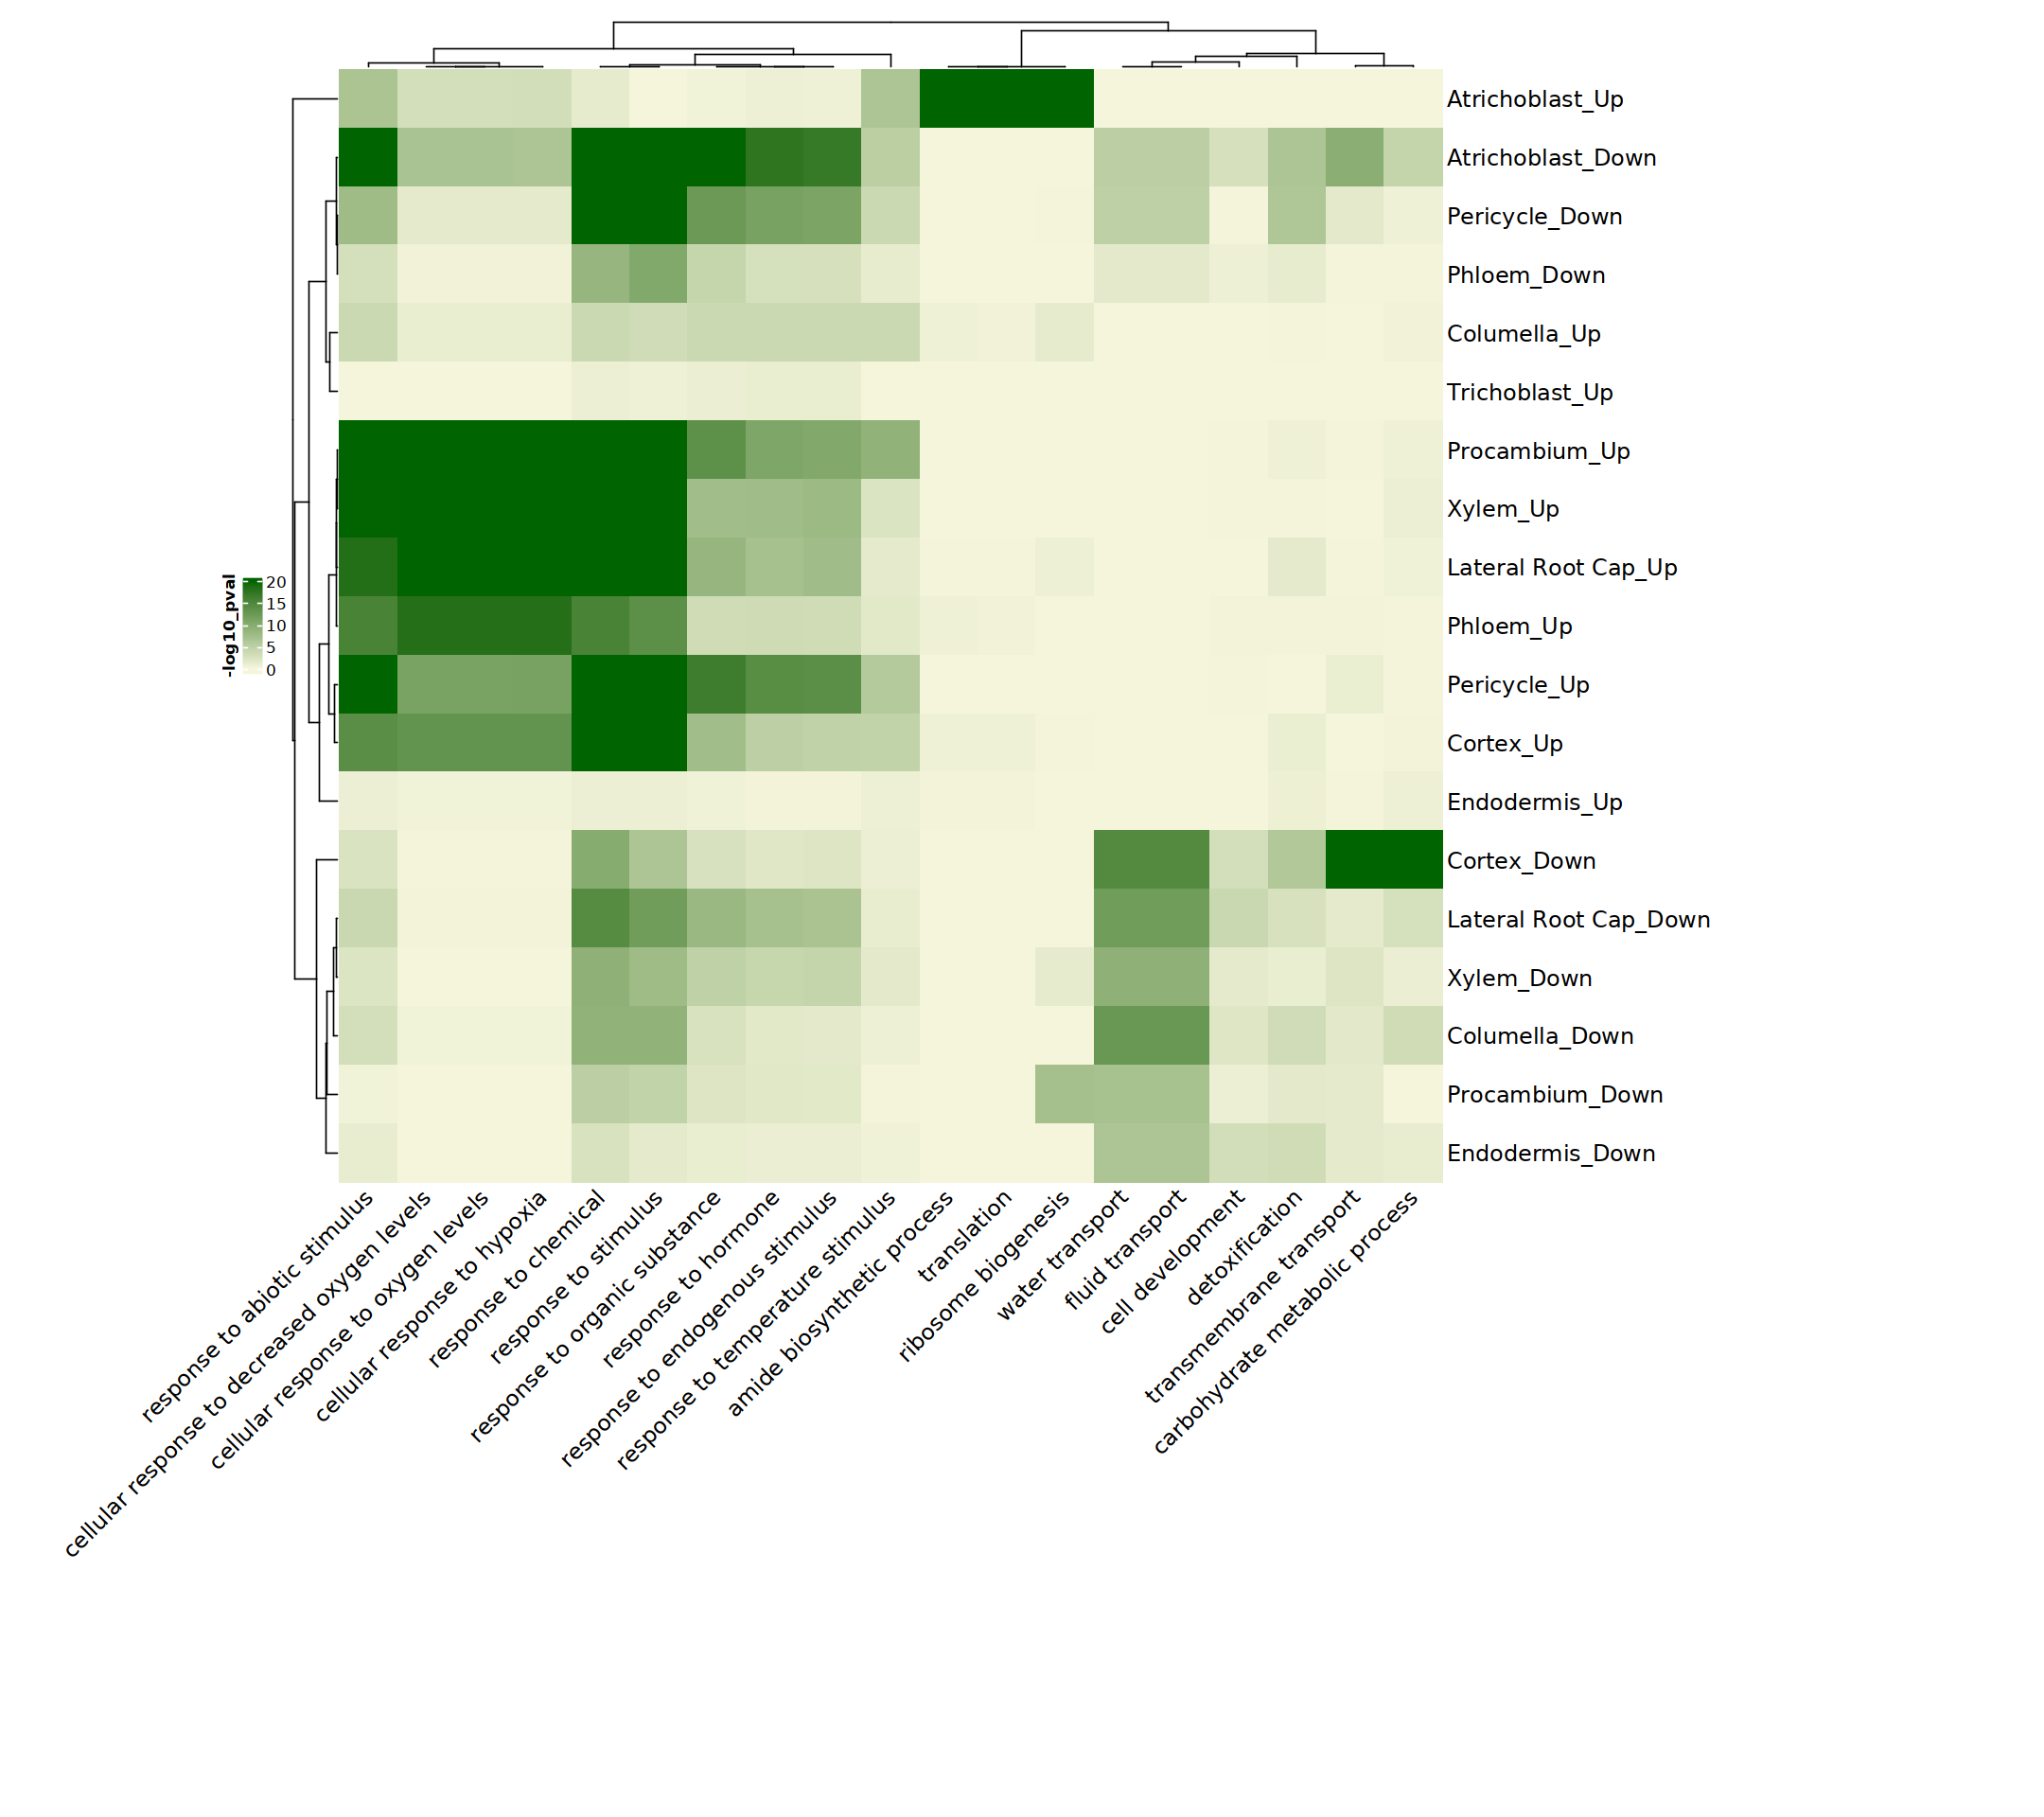

In [39]:
options(repr.plot.width = 18, repr.plot.height = 16)

# padding - bottom, left, top, right
draw(GO_hm_t, padding = unit(c(80, 50, 5, 80), "mm"), heatmap_legend_side = "left")

pdf(file = "../output/GL2/pGL2_vs_WT_GO_celltype.pdf", width=18, height=16)

draw(GO_hm_t, padding = unit(c(80, 50, 5, 80), "mm"), heatmap_legend_side = "left")

dev.off()

In [40]:
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Phloem","Protophloem", "Xylem", "Procambium","Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400D3", "#DCD0FF","#5AB953", "#BFEF45", "#008080", "#21B6A8", "#82B6FF", "#0000FF","#E6194B", "#DD77EC", "#9A6324", "#FFE119", "#FF9900", "#FFD4E3", "#9A6324", "#DDAA6F", "#EEEEEE")
integrated.de$cell_type <- factor(integrated.de$cell_type, levels = order[sort(match(unique(integrated.de$cell_type),order))])
color <- palette[sort(match(unique(integrated.de$cell_type),order))]

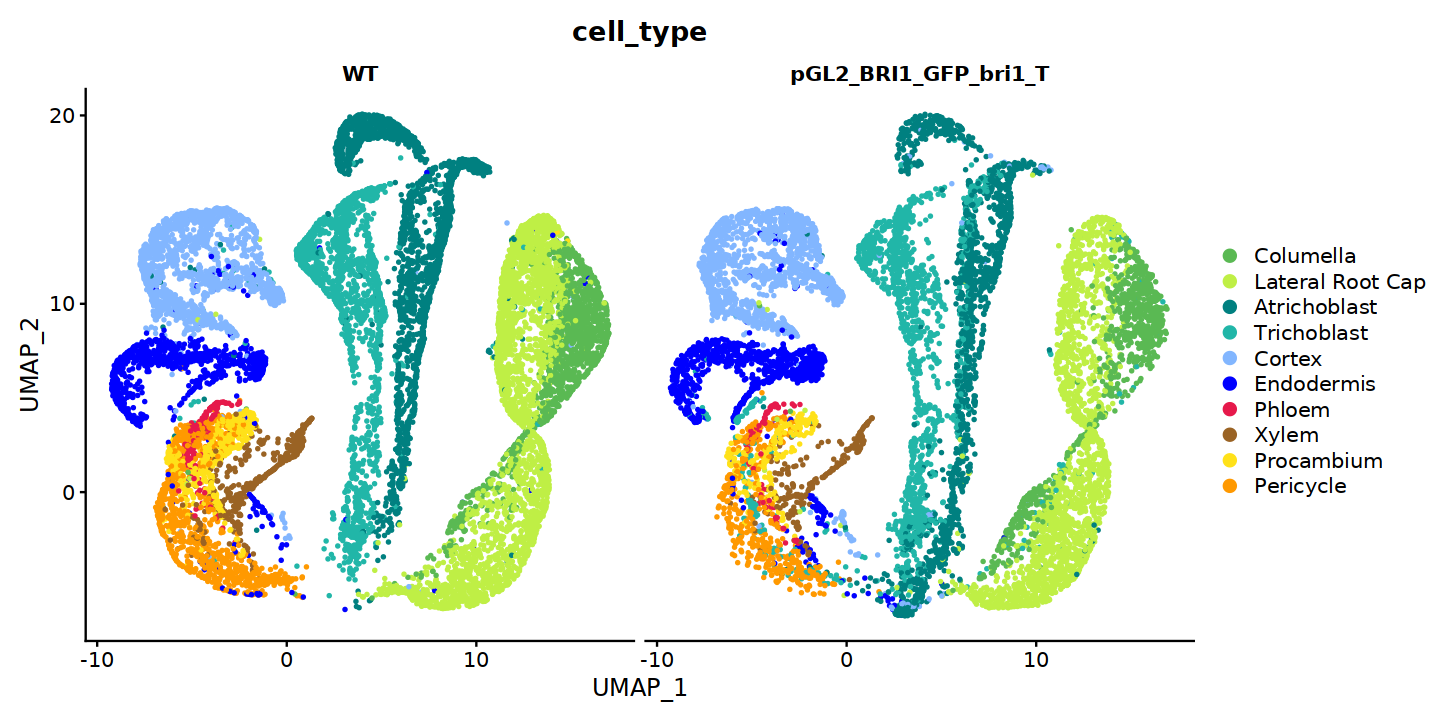

In [41]:
options(repr.plot.width=12, repr.plot.height=6)
(Celltype_umap <- DimPlot(integrated.de, 
                      reduction = "umap", 
                      group.by = "cell_type", 
                      cols = color, split.by = 'genotype', 
                      ncol=2, 
                      pt.size = 0.5))

ggsave("../output/GL2/Cell_type_umap_square.pdf", width=12, height=6)

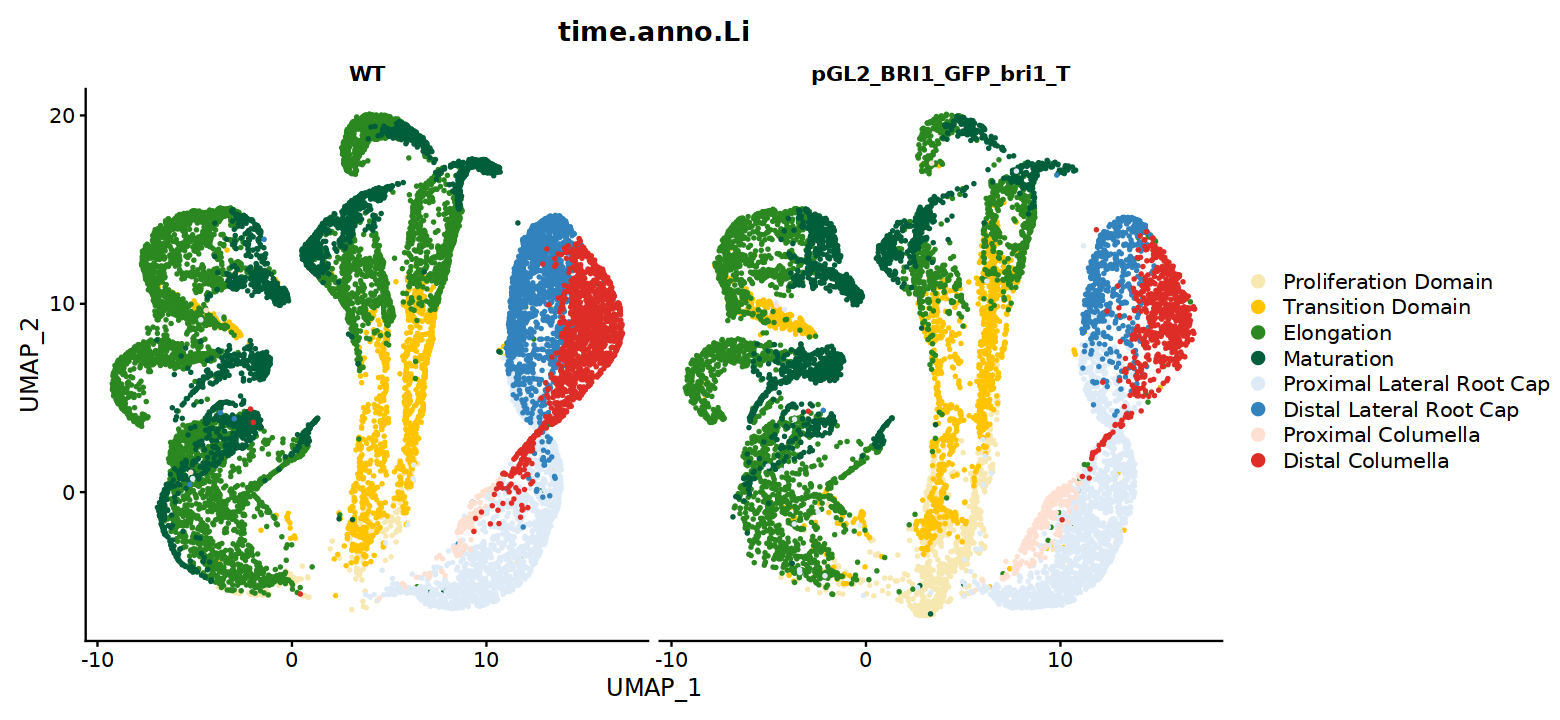

In [42]:
options(repr.plot.width=13, repr.plot.height=6)
DimPlot(integrated.de, 
        group.by = "time.anno.Li", 
                      split.by = 'genotype', 
        order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain"),
        cols = c('#F7E7B0','#FFC400','#2B871F','#005E3B', "#deebf7", "#3182bd", '#fee0d2','#de2d26'),
        ncol=2, 
        pt.size = 0.5)
ggsave("../output/GL2/Dev_stage_umap_square.pdf", width=13, height=6)

Warning message in FeaturePlot(integrated.de, features = "GL2-BRI1-GFP", split.by = "genotype", :
“All cells have the same value (0) of GL2-BRI1-GFP.”


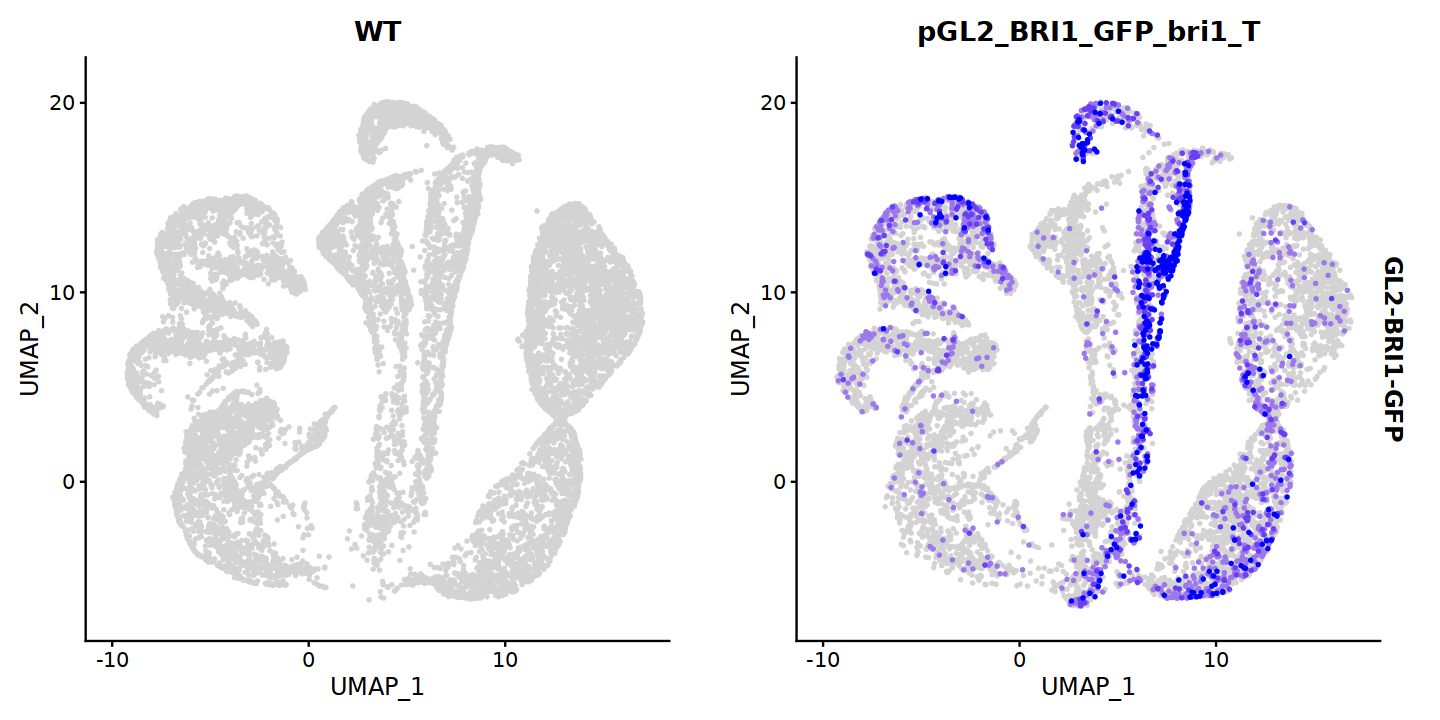

In [43]:
options(repr.plot.width = 12, repr.plot.height = 6)

DefaultAssay(integrated.de) <- "SCT"
# expression of the transgene
(BRI1_UMAP <- FeaturePlot(integrated.de, features="GL2-BRI1-GFP", split.by = "genotype", order=T, max.cutoff = "q90", pt.size = 0.5))

ggsave("../output/GL2/pGL2_BRI1-GFP_expression.pdf", width=12, height=6)

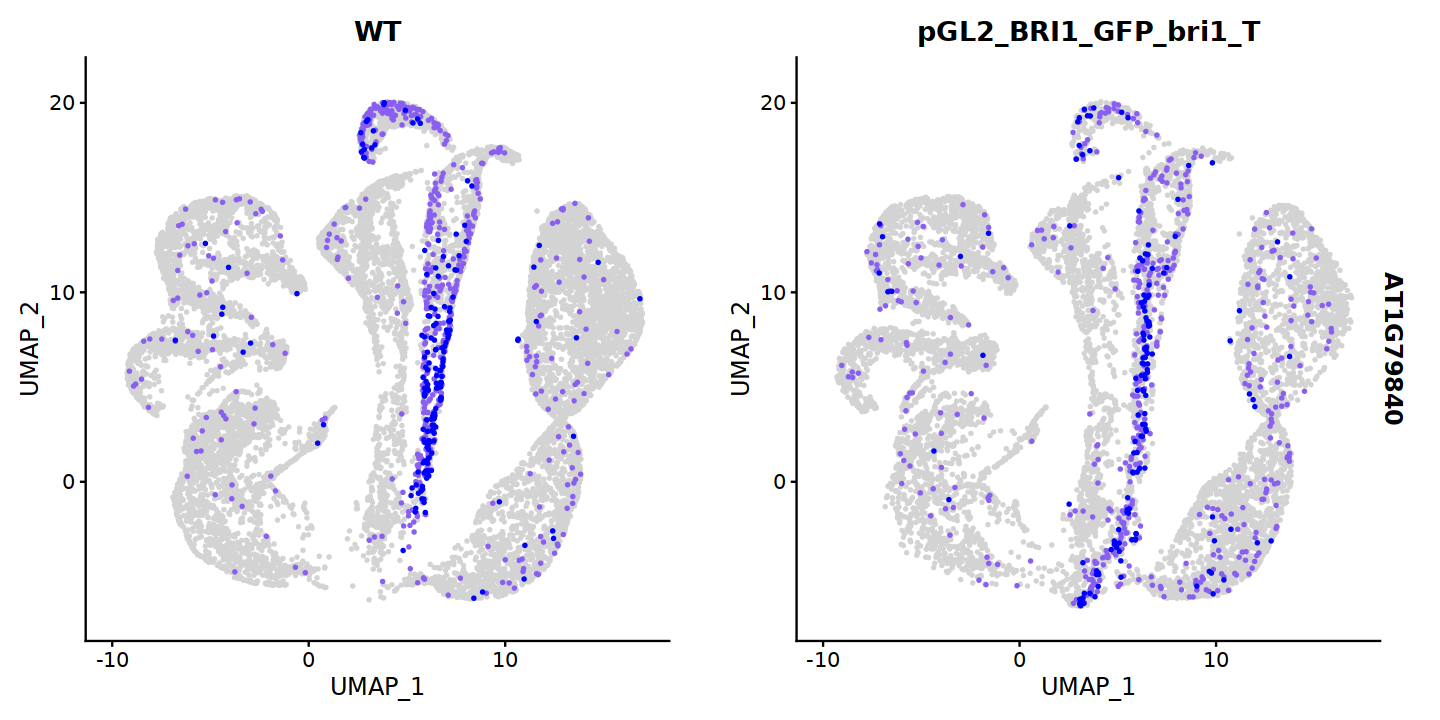

In [44]:
# expression of GL2
(GL2_UMAP <- FeaturePlot(integrated.de, features="AT1G79840", split.by = "genotype", order=T, max.cutoff = "q90", pt.size = 0.5))

ggsave("../output/GL2/GL2-AT1G79840_expression.pdf", width=12, height=6)

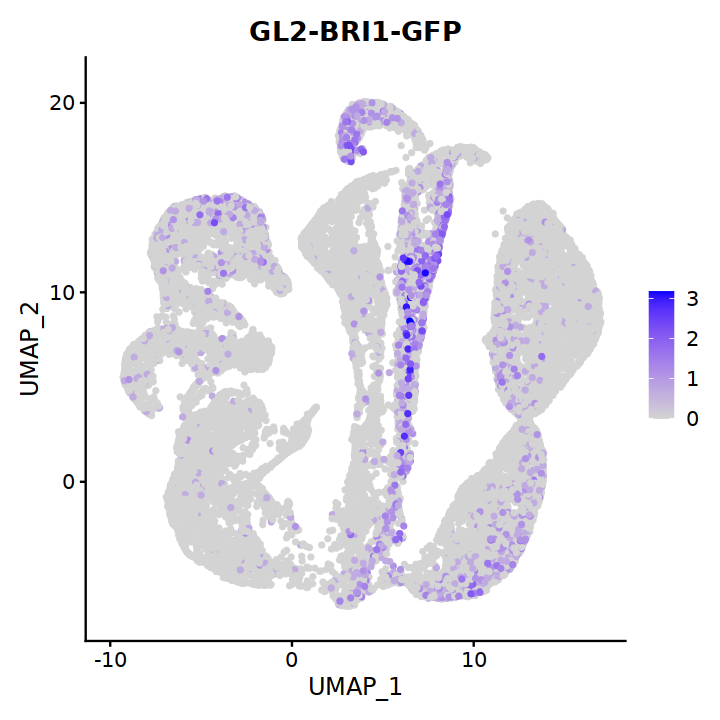

In [47]:
# save legend as PDF and update manually 
options(repr.plot.width = 6, repr.plot.height = 6)


FeaturePlot(integrated.de, reduction = "umap", features = "GL2-BRI1-GFP", pt.size=1)
ggsave("../output/GL2/UMAP_blue_legend.pdf", width=6, height=6)